In [6]:
from astdiff.ast.node import Node
from astdiff.ast.metadata import add_parents, attach_metadata


def get_source():
    """
    For visualization of the tree below, see figure 1 in page 4 of
    https://hal.archives-ouvertes.fr/hal-01054552/document
    """
    source_function_block = Node(
        label="Block",
        value="",
        children=(
            Node(
                label="IfStatement",
                value="",
                children=(
                    Node(
                        label="InfixExpression",
                        value="==",
                        children=(
                            Node(label="SimpleName", value="i", children=()),
                            Node(label="NumberLiteral", value="0", children=()),
                        ),
                    ),
                    Node(
                        label="ReturnStatement",
                        value="",
                        children=(
                            Node(label="StringLiteral", value="Foo!", children=()),
                        ),
                    ),
                ),
            ),
        ),
    )
    source_method_declaration = Node(
        label="MethodDeclaration",
        value="",
        children=(
            Node(label="Modifier", value="public", children=()),
            Node(
                label="SimpleType",
                value="String",
                children=(Node(label="SimpleName", value="String", children=()),),
            ),
            Node(label="SimpleName", value="foo", children=()),
            Node(
                label="SingleVariableDeclaration",
                value="",
                children=(
                    Node(
                        label="PrimitiveType",
                        value="int",
                        children=(),
                    ),
                    Node(label="SimpleName", value="i", children=()),
                ),
            ),
            source_function_block,
        ),
    )
    source = Node(
        label="CompilationUnit",
        value="",
        children=(
            Node(
                label="TypeDeclaration",
                value="",
                children=(
                    Node(label="Modifier", value="public", children=()),
                    Node(label="SimpleName", value="Test", children=()),
                    source_method_declaration,
                ),
            ),
        ),
    )

    add_parents(source)
    attach_metadata(source)

    return source


def get_target():
    """
    For visualization of the tree below, see figure 1 in page 4 of
    https://hal.archives-ouvertes.fr/hal-01054552/document
    """
    target_function_else_if = Node(
        label="IfStatement",
        value="",
        children=(
            Node(
                label="InfixExpression",
                value="==",
                children=(
                    Node(
                        label="SimpleName",
                        value="i",
                        children=(),
                    ),
                    Node(
                        label="PrefixExpression",
                        value="-",
                        children=(
                            Node(
                                label="NumberLiteral",
                                value="1",
                                children=(),
                            ),
                        ),
                    ),
                ),
            ),
            Node(
                label="ReturnStatement",
                value="",
                children=(
                    Node(
                        label="StringLiteral",
                        value="Foo!",
                        children=(),
                    ),
                ),
            ),
        ),
    )
    target_function_block = Node(
        label="Block",
        value="",
        children=(
            Node(
                label="IfStatement",
                value="",
                children=(
                    Node(
                        label="InfixExpression",
                        value="==",
                        children=(
                            Node(label="SimpleName", value="i", children=()),
                            Node(label="NumberLiteral", value="0", children=()),
                        ),
                    ),
                    Node(
                        label="ReturnStatement",
                        value="",
                        children=(
                            Node(label="StringLiteral", value="Bar", children=()),
                        ),
                    ),
                    target_function_else_if,
                ),
            ),
        ),
    )

    target_method_declaration = Node(
        label="MethodDeclaration",
        value="",
        children=(
            Node(label="Modifier", value="private", children=()),
            Node(
                label="SimpleType",
                value="String",
                children=(Node(label="SimpleName", value="String", children=()),),
            ),
            Node(label="SimpleName", value="foo", children=()),
            Node(
                label="SingleVariableDeclaration",
                value="",
                children=(
                    Node(label="PrimitiveType", value="int", children=()),
                    Node(label="SimpleName", value="i", children=()),
                ),
            ),
            target_function_block,
        ),
    )
    target = Node(
        label="CompilationUnit",
        value="",
        children=(
            Node(
                label="TypeDeclaration",
                value="",
                children=(
                    Node(label="Modifier", value="public", children=()),
                    Node(label="SimpleName", value="Test", children=()),
                    target_method_declaration,
                ),
            ),
        ),
    )

    add_parents(target)
    attach_metadata(target)

    return target

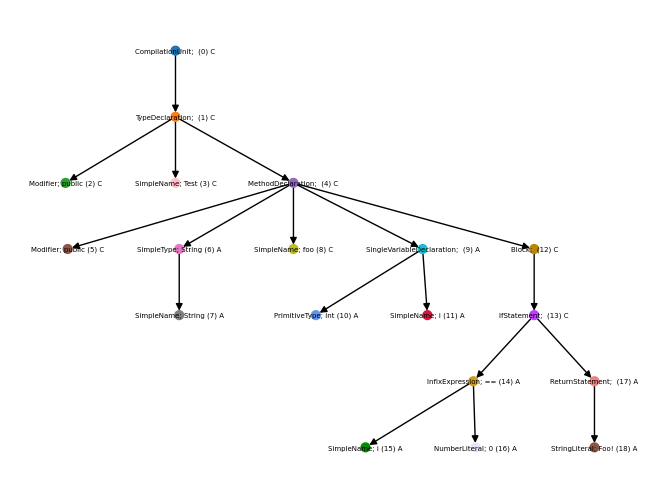

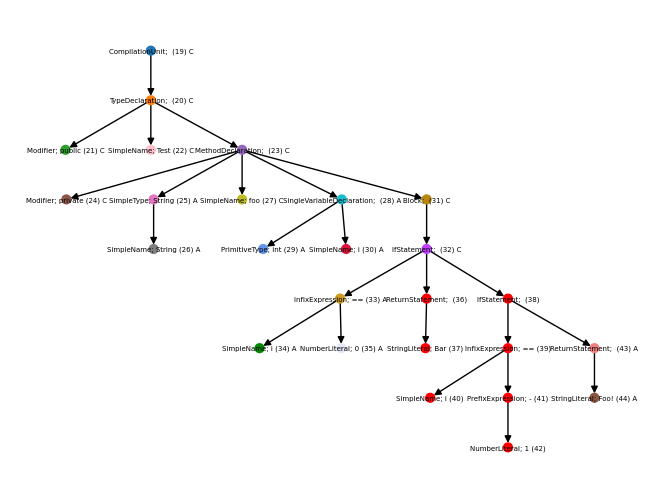

Update(node=Node(label='Modifier', value='private'), value='private')
Insert(node=Node(label='ReturnStatement', value=''), parent=Node(label='IfStatement', value=''), position=1)
Insert(node=Node(label='IfStatement', value=''), parent=Node(label='IfStatement', value=''), position=2)
Insert(node=Node(label='StringLiteral', value='Bar'), parent=Node(label='ReturnStatement', value=''), position=0)
Insert(node=Node(label='InfixExpression', value='=='), parent=Node(label='IfStatement', value=''), position=0)
Move(node=Node(label='ReturnStatement', value=''), parent=Node(label='IfStatement', value=''), position=1)
Insert(node=Node(label='SimpleName', value='i'), parent=Node(label='InfixExpression', value='=='), position=0)
Insert(node=Node(label='PrefixExpression', value='-'), parent=Node(label='InfixExpression', value='=='), position=1)
Insert(node=Node(label='NumberLiteral', value='1'), parent=Node(label='PrefixExpression', value='-'), position=0)


In [7]:
from astdiff.context import DiffContext
from astdiff.differ import diff
from itertools import count
from typing import Optional
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from astdiff.matcher.gumtree import GumTreeMatcher
from astdiff.generator.with_move import WithMoveEditScriptGenerator
from astdiff.ast.traversal import pre_order_walk

rep_cache = {}
nums = count()

ast1 = get_source()
ast2 = get_target()

context = DiffContext(ast1, ast2)

matcher = GumTreeMatcher()
matcher.prepare(context)

anchor_matches = matcher.match_anchors(context.source_root, context.target_root)
anchor_nodes = set(x.source for x in anchor_matches.pairs) | set(x.target for x in anchor_matches.pairs)
anchor_pairs = set((x.source, x.target) for x in anchor_matches.pairs)
anchors = set(x.source + x.target for x in anchor_matches.pairs)

context.matching_set = matcher.match_containers(context.source_root, context.target_root)
container_pairs = set((x.source, x.target) for x in context.matching_set.pairs) - anchor_pairs
container_nodes = set(s for s, t in container_pairs) | set(t for s, t in container_pairs)
containers = set(s + t for s, t in container_pairs)

def rep(x: Node):
    if id(x) not in rep_cache:
        rep_cache[id(x)] = f"{x.label}; {x.value} ({next(nums)})"
        if id(x) in anchor_nodes:
            rep_cache[id(x)] += " A"
        elif id(x) in container_nodes:
            rep_cache[id(x)] += " C"
    return rep_cache[id(x)]

match_color_map = {}
colors = (x.lower() for x in [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#FFC0CB', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#6495ED', '#DC143C', '#B8860B', '#BF3EFF', '#CD9B1D', '#008B00', '#E6E6FA', '#F08080', '#8B5742', 'orange',
])
def match_color(s: Node, t: Node):
    key = id(s) + id(t)
    if key not in match_color_map:
        match_color_map[key] = next(colors)
    return match_color_map[key]

def plot(tree: Node):
    source = nx.DiGraph()
    color_map = []
    def graph(node: Node):
        partner = context.partner(node)
        node_rep = rep(node)
        source.add_node(node_rep)
        if partner:
            color_map.append(match_color(node, partner))
        else:
            color_map.append("red")
        if node.parent:
            source.add_edge(rep(node.parent), node_rep)
        for child in node.children:
            graph(child)
    graph(tree)
    pos = graphviz_layout(source, prog="dot")
    nx.draw(source, pos, node_color=color_map, with_labels=True, node_size=40, font_size=5)
    plt.show()


plot(context.source_root)
plot(context.target_root)

context.edit_script = WithMoveEditScriptGenerator().generate_edit_script(context)
print(*context.edit_script, sep="\n")